#Dependencies

In [ ]:
!pip install qiskit==0.40.0
!pip install pylatexenc

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 6.5 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.40.0-py3-none-any.whl size=12819 sha256=572493

In [ ]:
from skimage.metrics import mean_squared_error, structural_similarity
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import execute, Aer
from PIL import Image
import numpy

#Images

In [ ]:
image1 = [[0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 1, 0, 0, 0, 0, 0],
          [0, 1, 1, 0, 0, 0, 0, 0],
          [0, 1, 1, 0, 0, 0, 0, 0],
          [0, 1, 1, 0, 0, 0, 0, 0],
          [0, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 1, 1, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0]]

image2 = [[0, 1, 1, 1, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0]]

image3 = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
          [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
          [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
          [0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
          [0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
          [0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
          [0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
          [0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
          [0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
          [0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
          [0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
          [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
          [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
          [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],]

image4 = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0],
          [0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0],
          [0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

#Base Encoder

In [ ]:
class QuantumEncoder:
    def __init__(self):
        self.Qregs : QuantumRegister = None
        self.Cregs : ClassicalRegister = None
        self.Qcirc : QuantumCircuit = None
        self.Qcirc2 : QuantumCircuit = None

    def createQuantumCircuit(self, *regs) -> None :
        return QuantumCircuit(*regs)

    def preProcessImage(self, image : Image.Image) -> Image.Image :
        '''
            This function makes sure that an image is in the form of 2^nx2^n.
            This is done since most encoders manage images of these size since
            it requires correct number of qubits.
        '''
        image = image.convert('L')  #Converting to Grayscale
        img = numpy.array(image)    #Converting image to a numpy array
        squareSize = max(2**int(numpy.ceil(numpy.log2(image.size[0]))), 2**int(numpy.ceil(numpy.log2(image.size[1]))))  #Calculating size of square to accomodate image
        new_img = numpy.zeros((squareSize,squareSize))  #Creating an array to store new image
        for i in range(image.size[1]):
            for j in range(image.size[0]):
                new_img[i, j] = img[i, j]
        return Image.fromarray(new_img)

    def encode(self, image : Image.Image) -> None :
        pass

    def decode(self, circuit : QuantumCircuit) -> None:
        pass

    def detectEdges(self, image:Image.Image):
        pass

    def calculateMSE(self, image1 : Image.Image, image2 : Image.Image):
        img1_array = numpy.array(image1)
        img2_array = numpy.array(image2)
        mse = mean_squared_error(img1_array, img2_array)
        return mse

    def calculateSSI(self, image1 : Image.Image, image2 : Image.Image):
        img1_array = numpy.array(image1)
        img2_array = numpy.array(image2)
        ssim = structural_similarity(img1_array, img2_array, multichannel=False, data_range=255)
        return ssim

#QPIE

In [ ]:
class QPIE(QuantumEncoder):
    def __init__(self):
        pass

    def amplitudeEncoder(self, img : numpy.ndarray) :
        img = img.astype(numpy.float64)
        rms = numpy.sqrt(numpy.sum(numpy.sum(img**2, axis=1)))
        amplitudes = (img/rms).reshape(img.shape[0]**2)
        # print(amplitudes)
        # print(numpy.sum(amplitudes**2))
        return amplitudes

    def encode(self, image : Image.Image) -> None :
        img = numpy.array(image)
        h_amplitudes = self.amplitudeEncoder(img)
        v_amplitudes = self.amplitudeEncoder(img.T)

        controlbits = int(2 * numpy.log2(img.shape[0]))
        unitaryMatrix = numpy.identity(2**(controlbits+1))
        unitaryMatrix = numpy.roll(unitaryMatrix,1,axis=1)

        # positions = QuantumRegister(controlbits, 'position')
        # target = QuantumRegister(1, 'target')
        # classical = ClassicalRegister(controlbits+1, 'measure')


        # self.Qcirc = self.createQuantumCircuit(positions, target, classical)
        self.Qcirc = QuantumCircuit(controlbits+1)
        self.Qcirc.initialize(h_amplitudes, range(1, controlbits+1))
        self.Qcirc.h(0)
        self.Qcirc.unitary(unitaryMatrix, range(controlbits+1))
        self.Qcirc.h(0)

        # self.Qcirc2 = self.createQuantumCircuit(positions, target, classical)
        self.Qcirc2 = QuantumCircuit(controlbits+1)
        self.Qcirc2.initialize(v_amplitudes, range(1, controlbits+1))
        self.Qcirc2.h(0)
        self.Qcirc2.unitary(unitaryMatrix, range(controlbits+1))
        self.Qcirc2.h(0)

        # print(self.Qcirc)
        # self.Qcirc2.draw('mpl', fold=-1)

    def decode(self, simulator : str, shots: int = 2**16) -> Image.Image :
        pass

    def detectEdges(self) -> Image.Image:
        back = Aer.get_backend('statevector_simulator')
        # self.Qcirc2.draw('mpl', fold=-1)
        results = execute([self.Qcirc, self.Qcirc2], backend=back).result()
        state_vector_h = results.get_statevector(self.Qcirc)
        state_vector_v = results.get_statevector(self.Qcirc2)


        size = int(2**((self.Qcirc.num_qubits-1)/2))
        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
        h_edge_scan_img = numpy.abs(numpy.array([1 if threshold(state_vector_h[(2*i)+1].real) else 0 for i in range(2**(self.Qcirc.num_qubits-1))])).reshape(size, size)
        v_edge_scan_img = numpy.abs(numpy.array([1 if threshold(state_vector_v[(2*i)+1].real) else 0 for i in range(2**(self.Qcirc2.num_qubits-1))])).reshape(size, size).T

        edge_scan_image = h_edge_scan_img | v_edge_scan_img
        return edge_scan_image, h_edge_scan_img, v_edge_scan_img

In [ ]:
def showdiff(Encoder : QuantumEncoder, *images : Image.Image):
    # print('MSE: ',Encoder.calculateMSE(image1, image2))
    # try:
    #     print('SSI: ', Encoder.calculateSSI(image1, image2))
    # except:
    #     pass
    fig = plt.figure()
    for i in range(len(images)):
        fig.add_subplot(1,len(images),i+1)
        plt.imshow(images[i], cmap='gray')
    plt.show()

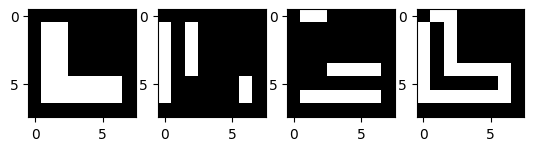

In [ ]:
Encoder = QPIE()

# image1 = Encoder.preProcessImage(Image.open('./testimages/test4edges.png').convert('L'))
img = image1
Encoder.encode(img)
outimage,h,v = Encoder.detectEdges()
showdiff(Encoder, img, h, v, outimage)

#FRQI

In [ ]:
class FRQI(QuantumEncoder):
    def __init__(self):
        pass

    def encode(self, image : Image.Image) -> None :
        '''
            This function encodes the corresponding angle values of each element
            onto the Quantum Circuit.
        '''
        angles_h = numpy.arcsin(numpy.array(image))
        angles_h = angles_h.reshape(angles_h.shape[0]**2)
        angles_v = numpy.arcsin(numpy.array(image).T)
        angles_v = angles_v.reshape(angles_v.shape[0]**2)

        controlbits = int(numpy.log2(angles_h.shape[0]))
        positions = QuantumRegister(controlbits, 'position')
        target = QuantumRegister(1, 'target')
        classical = ClassicalRegister(controlbits+1, 'measure')
        self.Qcirc = self.createQuantumCircuit(target, positions, classical)
        self.Qcirc2 = self.createQuantumCircuit(target, positions, classical)

        #FRQI process starts here
        for i in range(1, controlbits+1):
            self.Qcirc.h(i)
            self.Qcirc2.h(i)

        j = 0
        for i in angles_h:
            state = '{0:0{1}b}'.format(j - 1, controlbits)
            new_state = '{0:0{1}b}'.format(j, controlbits)
            if j != 0:
                c = numpy.array([])
                for k in range(controlbits):
                    if state[k] != new_state[k]:
                        c = numpy.append(c, int(k))
                if len(c) > 0:
                    self.Qcirc.x(numpy.abs(c.astype(int) - (controlbits)))
            cry = RYGate(2 * i).control(controlbits)
            aux = numpy.append([i+1 for i in range(controlbits)], 0).tolist()
            self.Qcirc.append(cry, aux)
            j += 1

        self.Qcirc.measure(0, 0)

        j = 0
        for i in angles_v:
            state = '{0:0{1}b}'.format(j - 1, controlbits)
            new_state = '{0:0{1}b}'.format(j, controlbits)
            if j != 0:
                c = numpy.array([])
                for k in range(controlbits):
                    if state[k] != new_state[k]:
                        c = numpy.append(c, int(k))
                if len(c) > 0:
                    self.Qcirc2.x(numpy.abs(c.astype(int) - (controlbits)))
            cry = RYGate(2 * i).control(controlbits)
            aux = numpy.append([i+1 for i in range(controlbits)], 0).tolist()
            self.Qcirc2.append(cry, aux)
            j += 1

        self.Qcirc2.measure(0, 0)

        backend_sim = Aer.get_backend('statevector_simulator')
        job = execute([self.Qcirc, self.Qcirc2], backend_sim)
        result = job.result()
        counts = result.get_counts()
        val = max(zip(counts[0].values(), counts[0].keys()))[1]
        if val[controlbits] == 0:
          self.Qcirc.id(0)
        else:
          self.Qcirc.x(0)

        val = max(zip(counts[1].values(), counts[1].keys()))[1]
        if val[controlbits] == 0:
          self.Qcirc2.id(0)
        else:
          self.Qcirc2.x(0)

        unitaryMatrix = numpy.identity(2**(controlbits+1))
        unitaryMatrix = numpy.roll(unitaryMatrix,1,axis=1)
        self.Qcirc.h(0)
        self.Qcirc.unitary(unitaryMatrix, range(controlbits+1))
        self.Qcirc.h(0)

        unitaryMatrix = numpy.identity(2**(controlbits+1))
        unitaryMatrix = numpy.roll(unitaryMatrix,1,axis=1)
        self.Qcirc2.h(0)
        self.Qcirc2.unitary(unitaryMatrix, range(controlbits+1))
        self.Qcirc2.h(0)

    def decode(self, simulator : str, shots: int = 2**16) -> Image.Image:
        n = [i for i in range(self.Qcirc.num_qubits)]
        self.Qcirc.measure(n, n)
        backend_sim = Aer.get_backend(simulator)

        job = execute(self.Qcirc, backend_sim, shots=shots)
        result = job.result()
        counts = result.get_counts(self.Qcirc)

        pixels = 2 ** (self.Qcirc.num_qubits - 1)
        picture_side = int(numpy.sqrt(pixels))
        binary_length = self.Qcirc.num_qubits - 1

        shots = counts.shots()

        retrieved_image = numpy.array([])
        for i in range(pixels):
            try:
                s = format(i, '0{0}b'.format(binary_length))
                new_s = '1' + s
                retrieved_image = numpy.append(retrieved_image, numpy.sqrt(counts[new_s] / shots))
            except KeyError:
                retrieved_image = numpy.append(retrieved_image, [0.0])

        retrieved_image = numpy.real(retrieved_image)
        retrieved_image *= picture_side * 255.0
        retrieved_image = numpy.floor((retrieved_image/100))
        retrieved_image = retrieved_image.astype(numpy.uint8)
        retrieved_image = retrieved_image.reshape((picture_side, picture_side))
        return Image.fromarray(retrieved_image)

    def detectEdges(self) -> Image.Image:
        back = Aer.get_backend('statevector_simulator')
        results = execute([self.Qcirc, self.Qcirc2], backend=back).result()
        state_vector_h = results.get_statevector(self.Qcirc)
        state_vector_v = results.get_statevector(self.Qcirc2)


        size = int(2**((self.Qcirc.num_qubits-1)/2))
        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
        h_edge_scan_img = numpy.abs(numpy.array([1 if threshold(state_vector_h[(2*i)+1].real) else 0 for i in range(2**(self.Qcirc.num_qubits-1))])).reshape(size, size)
        v_edge_scan_img = numpy.abs(numpy.array([1 if threshold(state_vector_v[(2*i)+1].real) else 0 for i in range(2**(self.Qcirc2.num_qubits-1))])).reshape(size, size).T

        edge_scan_image = h_edge_scan_img | v_edge_scan_img
        return edge_scan_image, h_edge_scan_img, v_edge_scan_img

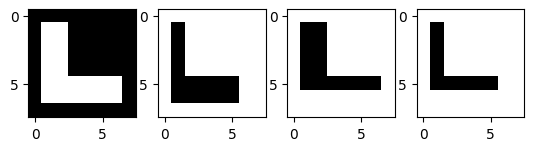

In [ ]:
FRQIEncoder = FRQI()
img = image1
FRQIEncoder.encode(img)
# outimage = FRQIEncoder.decode('aer_simulator', shots=2**24)
outimage,h,v = FRQIEncoder.detectEdges()
showdiff(FRQIEncoder, img, h, v, outimage)